# IFT870 - Examen intratrimestriel

Auteur : Aurélien Vauthier (19 126 456)

In [33]:

# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

# extract data
journal = pd.read_csv("api_journal11-13-17.csv", encoding="latin1")
price = pd.read_csv("api_price11-13-17.csv", index_col=0)
influence = pd.read_csv("estimated-article-influence-scores-2015.csv", index_col=0)

## Question 1 : Exploration-Description

*Présenter une description de chacun des attributs des 3 tables, avec des graphiques
pour la visualisation des statistiques descriptives au besoin.*

### Table `journal`

In [ ]:

# show the first values
journal.head()

Nous pouvons déjà observer les colonnes suivantes et imaginer une petite description : 
- **issn** (valeur numérique) : ([International Standard Serial Number](https://fr.wikipedia.org/wiki/International_Standard_Serial_Number)),
il s'agit d'un numéro permettant d'identifier une série de publication de façon unique.
- **journal_name** (valeur catégorique) : Le nom du journal
- **pub_name** (valeur catégorique) : Le nom de l'éditeur
- **is_hybrid** (valeur booléenne) : (D'après le site [FlourishOA](http://flourishoa.org/about#type)) Permet de savoir si le journal est
hybride. C'est-à-dire, si le journal est à abonnement avec certains articles en accès libre.
- **category** (valeur catégorique) : La liste des catégories de la revue scientifique.
- **url** (valeur catégorique) : L'adresse web de la page d'acceuil du journal

In [ ]:

#  Compute ratio of N/A values
(journal.isna().sum() / journal.shape[0]) * 100

Nous pouvons remarquer que les colonnes `pub_name`, `category` et `url` possèdent des données manquantes. En particulier
`category` et `url` qui ont environs 50% de données manquantes.

In [ ]:

# Compute ratio of unique values
print(f"Ratio de valeurs uniques pour l'index : {len(np.unique(journal.index)) / journal.shape[0]:.0%}")
print(f"Ratio de valeurs uniques pour issn : {journal['issn'].nunique() / journal.shape[0]:.0%}")

L'index et les ISSN sont bien unique.

La colonne `journal_name` ne semble pas avoir de problème mis à part quelques données dupliquées.

In [ ]:

# sort and print the 10 biggest publishers
pub, count = np.unique(journal["pub_name"].dropna(), return_counts=True)
print("Nombre de revue par éditeur :")
for pub, count in sorted(zip(pub.tolist(), count.tolist()), key=lambda x: x[1], reverse=True)[:10]:
    print(f"\t- {pub} : {count} ({count/journal.shape[0]:.2%})")

On peut voir qu'il existe de gros éditeurs, en particulier `Springer` qui publie 14.3% des revues scientifiques. 

In [ ]:

# convert to bool values
journal["is_hybrid"] = journal["is_hybrid"].astype(bool)
print(f"Ratio de revues hybrides : {journal['is_hybrid'].sum() / journal.shape[0]:.2%}")

On peut voir qu'il existe de gros éditeurs, en particulier `Springer` qui publie 14.3% des revues scientifiques.

In [ ]:

journal["category"][11065:11070]

Comme on peut le voir sur l'exemple ci-dessus, certaines revues possèdent plusieurs catégorie qui peuvent être séprarer
par plusieurs caractères comme `|`, `.` et `and`.

Finalement, pour la colonne `url`, il y a une grande partie de données manquantes mais 

### Table `price`

In [ ]:

# show the first values
price.head()

Nous pouvons déjà observer les colonnes suivantes et imaginer une petite description :
- **price** (valeur continue) : le prix de l'ACP (Article Publication Charge)
- **date_stamp** (valeur temporelle) : horodatage représentant la date de création de l'entrée.
- **journal_id** (valeur catégorique) : il s'agit de l'ISSN du journal
- **influence_id** (valeur catégorique) : on pourrait supposer qu'il s'agit d'un lien vers les lignes de la table
`influence` mais la majorité des id situés dans cette colonne sont supérieurs au nombre de lignes que possède la table
`influence` ce qui consititue alors des valeurs abérantes.
- **url** (valeur catégorique) : L'adresse web de la revue vers la page d'informations pour les auteurs.
- **license** (valeur catégorique) : Valeur numérique représentant une lisence (nous n'avons pas d'information sur la
correspondance entre les valeurs numériques et les différentes lisences qui existent.

In [ ]:

#  Compute ratio of N/A values
(price.isna().sum() / price.shape[0]) * 100

Nous pouvons remarquer que les colonnes `influence_id`, `url` et `license` possèdent presque uniquement des données
manquantes.

In [ ]:

print("Statistiques de la colonne price:")
print(f"- min : {price['price'].min():.0f}")
print(f"- max : {price['price'].max():.0f}")
print(f"- moyenne : {price['price'].mean():.3f}")
print(f"- varience : {price['price'].var():.3f}")
sns.distplot(price["price"])

On remarque sur le graphique 4 groupes de prix des journaux. Un premier à 0, un deuxième entre 100 et 2900 environ, un
troisième autour de la valeur 3000 et finalement un dernier groupe au-dessus de 3100.

In [ ]:

price["date_stamp"] = pd.to_datetime(price["date_stamp"], format="%Y-%m-%d")
groupedPrice = price["date_stamp"].groupby(price["date_stamp"].dt.year, sort=False)
years, years_count = [], []
for year in groupedPrice:
    years.append(year[0])
    years_count.append(year[1].shape[0])

plt.hist(years, bins=len(years), weights=years_count)
plt.show()

On note sur le graphique que la plupart des données ont été ajouté en 2016 et 2017, une autre partie fut ajouté en 2012
et 2013. La majorité des données est donc assez récente.

In [ ]:
def multicolumn_duplicate_ratio(df, columns):
    flatten_array = df[columns].values.ravel('K')
    n_unique = len(pd.unique(flatten_array))
    return n_unique / df.shape[0]


# Compute ratio of unique values
print(f"Ratio de valeurs uniques pour journal_id : {price['journal_id'].nunique() / price.shape[0]:.0%}")
print(f"Ratio de valeurs uniques pour (journal_id, date_stamp) : {multicolumn_duplicate_ratio(price, ['date_stamp', 'journal_id']):.0%}")

Contrairement à la table `journal` il existe plusieurs duplicatas des ISSN, en effet, certaines revues scientifiques
ont eu des mise à jours de leurs informations.

In [ ]:

# show ratio of incoherent values
print(f"Ratio de valeurs incohérentes pour influence_id : {1 - (price['influence_id'] <= influence.index[-1]).sum() / price.shape[0]:.2%}")

La quasi-totalité des valeurs de `influence_id` sont soit manquantes soit ont une valeur supérieur à la valeur maximal
des id de la table `influence`. Cette colonne ne semble donc pas être utile.

In [ ]:

print("Valeur(s) abérente(s) pour la colonne url :")
price[~price["url"].str.startswith("http", na=True)]["url"]

Bien qu'on ne retrouve qu'une seule valeur abérante, la majorité des valeurs reste manquente. Cela nuit donc à l'interêt
de cette colonne.

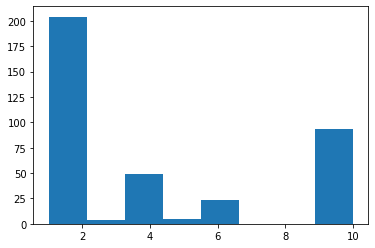

In [35]:

licenses, licenses_count = np.unique(price["license"].dropna(), return_counts=True)
plt.hist(licenses, bins=len(licenses), weights=licenses_count)
plt.show()

## Question 2 : Prétraitement-Représentation

*Effectuer un prétraitement des données pour supprimer les duplications et corriger les
incohérences s’il y en a.*

In [ ]:
journal["is_hybrid"] = journal["is_hybrid"].astype(bool)


*Y a t il une corrélation entre les catégories de journaux (attribut « category ») et les
coûts de publication (attribut « price ») ? Justifier la réponse.*

*Construire un modèle pour prédire les valeurs de catégorie de journaux manquantes de
la façon la plus précise possible (cela inclut la sélection d’attributs informatifs, le
choix et le paramétrage d’un modèle de classification, le calcul du score du modèle,
l’application du modèle pour prédire les catégories manquantes). Justifier les choix
effectués.*

## Question 3 : Régression-Clustering

*Supprimer tous les attributs ayant plus de 50% de données manquantes.*

*Construire un modèle pour prédire le coût actuel de publication (attribut « price ») à
partir des autres attributs (cela inclut la sélection d’attributs informatifs, le choix et le
paramétrage d’un modèle de régression, le calcul du score du modèle, l’application du
modèle pour prédire les coûts). Justifier les choix effectués.
Lister les 10 revues qui s’écartent le plus (en + ou -) de la valeur prédite.*

*Construire un modèle pour grouper les revues suivant le coût actuel de publication
(attribut « price ») et le score d’influence (attribut « proj_ai ») (cela inclut la
détermination du nombre de clusters, le choix et le paramétrage d’un modèle de
clustering, l’application du modèle pour trouver les clusters). Justifier les choix
effectués.*

*Présenter des statistiques descriptives des clusters obtenus, et lister les revues du
meilleur cluster en termes de rapport moyen : score d’influence / coût de publication.*